
# Kelompok Argozt
- **Ziyad Fathir Al Biaroza** - 103012300455
- **I Gede Krisna Ganesha Widhiarta** - 1030123
- **I Putu Justine Budi Wijaya** - 1030123

Pengelolaan sampah yang efektif memerlukan proses pemilahan yang tepat sesuai dengan jenisnya. Namun, proses pemilahan tersebut masih sering dilakukan secara manual sehingga kurang efisien. Oleh karena itu, proyek ini bertujuan untuk menerapkan metode kecerdasan artifisial dalam melakukan klasifikasi jenis sampah berdasarkan teks.

Pada proyek ini digunakan metode Naive Bayes yang diimplementasikan secara manual tanpa memanfaatkan library pembelajaran mesin siap pakai. Proses yang dilakukan meliputi pengambilan dataset, text preprocessing, ekstraksi fitur berbasis n-gram, perhitungan probabilitas, serta evaluasi performa model menggunakan metrik akurasi dan F1-Score. Melalui pendekatan ini, diharapkan sistem mampu mengklasifikasikan jenis sampah secara otomatis dan memberikan pemahaman mengenai penerapan Naive Bayes pada permasalahan klasifikasi teks.

1. Import Library

In [39]:
import pandas as pd #Untuk kelola dataset tabular
import numpy as np #Untuk komputasi numerik
import math #Untuk fungsi matematika
import re #Untuk pemrosesan teks
import json #Untuk manipulasi data JSON
import matplotlib.pyplot as plt #Untuk visualisasi data
from datasets import load_dataset #Untuk memuat dataset dari Hugging Face Datasets


2. Load Dataset

Pada tahap ini berfungsi untuk mengambil dataset waste-classification-v3 dari HuggingFace dan mengubah format menjadi pandas DataFrame

In [40]:
ds = load_dataset("thomasavare/waste-classification-v3") #Dataset ini bertipe DatasetDict
df = ds["train"].to_pandas() #Mengubah dataset train menjadi dataframe pandas

df.head() 

,Unnamed: 0,Phrase,Class,Class_index
0,26083,"I have this wooden fork, where should I throw ...",WOODEN CUTLERY,47.0
1,22232,"Excuse me, can you help me ? I don't know wher...",MIXED PAPER-PLASTIC PACKAGING,37.0
2,9728,Where can I throw my sony phone ?,SMARTPHONE,16.0
3,14402,what bin is best suited for my biodegradable p...,PAPER PACKAGING,21.0
4,21070,"Hey, I'm going to throw this plastic containers",PLASTIC DISH,34.0


3. Exploratory Data Analysis

Tahap ini berguna untuk melihat dan memahami dataset. EDA menjadi bagian penting pada proyek ini karena dataset yang berbasis teks, memiliki banyak kelas dan akan digunakan untuk Naive Bayes.

Ukuran dataset: (16146, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16146 entries, 0 to 16145
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16146 non-null  int64  
 1   Phrase       16146 non-null  object 
 2   Class        16146 non-null  object 
 3   Class_index  16146 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 504.7+ KB


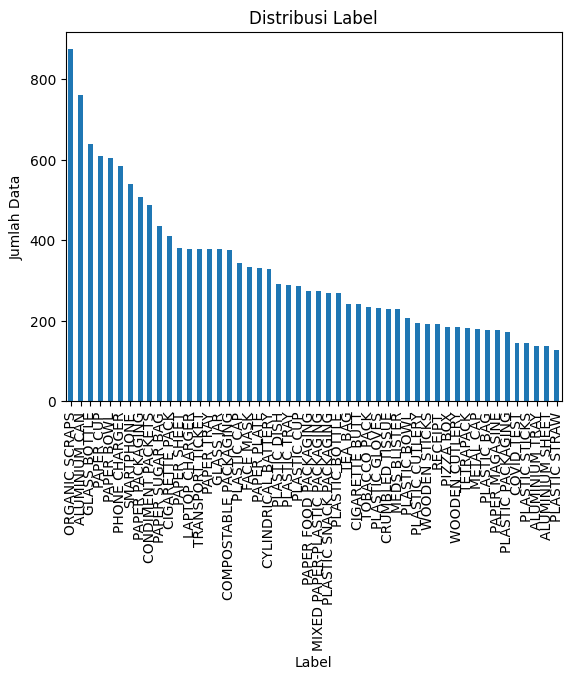

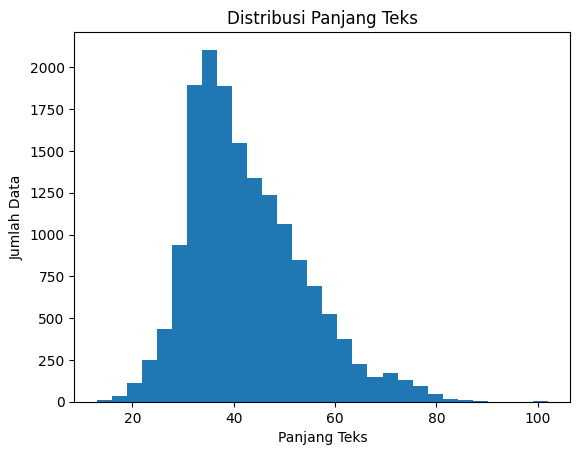

In [ ]:
#Ukuran dataset
print("Ukuran dataset:", df.shape)

#Struktur kolom
df.info()

#Distribusi Label
df['Class'].value_counts()

#Visualisasi Distribusi Label
df['Class'].value_counts().plot(kind='bar')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.show()

#Melihat teks panjang atau tidak
df['text_length'] = df['Phrase'].apply(len)
df['text_length'].describe()

#Visualisasi Panjang Teks
plt.hist(df['text_length'], bins=30) 
plt.title("Distribusi Panjang Teks")
plt.xlabel("Panjang Teks")
plt.ylabel("Jumlah Data")
plt.show()

4. Text Preprocessing

Pada tahap ini merupakan proses membersihkan teks agar konsisten. Ini penting karena konsep Naive Bayes bekerja dengan menghitung frekuensi kata dan menghitung probabilitas kemunculan kata tiap kelas. Jika tidak dibersihkan dapat terjadi duplikasi data pada makna yang sama.

In [42]:
#Lowercase
df['Phrase'] = df['Phrase'].str.lower()

#Hapus tanda baca
df['Phrase'] = df['Phrase'].str.replace(r'[^\w\s]', '', regex=True)

#Hapus spasi ekstra
df['Phrase'] = df['Phrase'].str.strip()

#Tokenisasi
df['tokens'] = df['Phrase'].str.split()

#Keluaran hasil preprocessing
df[['Phrase', 'tokens']].head()


,Phrase,tokens
0,i have this wooden fork where should i throw it,"[i, have, this, wooden, fork, where, should, i..."
1,excuse me can you help me i dont know where t...,"[excuse, me, can, you, help, me, i, dont, know..."
2,where can i throw my sony phone,"[where, can, i, throw, my, sony, phone]"
3,what bin is best suited for my biodegradable p...,"[what, bin, is, best, suited, for, my, biodegr..."
4,hey im going to throw this plastic containers,"[hey, im, going, to, throw, this, plastic, con..."


5. Feature Extraction (N-gram)

Pada tahap ini data mentah diubah menjadi fitur numerik yang bisa diproses oleh algoritma. Pada implementasi proyek ini hanya digunakan N(1) = Unigram dan N(2) Bigram, kombinasi keduanya telah cukup untuk menangkap makna teks agar dapat mencapai titik optimal antara performansi dan kompleksitas fitur.

In [43]:
#Fungsi untuk menghasilkan n-grams
def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = ' '.join(tokens[i:i+n])
        ngrams.append(ngram)
    return ngrams

#Menggabungkan unigram dan bigram
def extract_features(tokens):
    unigrams = generate_ngrams(tokens, 1)
    bigrams = generate_ngrams(tokens, 2)
    return unigrams + bigrams

#Aplikasikan ke seluruh dataset
df['features'] = df['tokens'].apply(extract_features)

#Tampilan hasil ekstraksi fitur
df[['Phrase', 'features']].head()

,Phrase,features
0,i have this wooden fork where should i throw it,"[i, have, this, wooden, fork, where, should, i..."
1,excuse me can you help me i dont know where t...,"[excuse, me, can, you, help, me, i, dont, know..."
2,where can i throw my sony phone,"[where, can, i, throw, my, sony, phone, where ..."
3,what bin is best suited for my biodegradable p...,"[what, bin, is, best, suited, for, my, biodegr..."
4,hey im going to throw this plastic containers,"[hey, im, going, to, throw, this, plastic, con..."


6. Implementasi Naive Bayes

7. Evaluasi (Accuracy, F1, dst)

8. (Opsional) Genetic Algorithm

9. Kesimpulan